### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

Could not find No module named 'assimulo.solvers.sundials'
Could not find No module named 'assimulo.solvers.kinsol'
/home/wredi/.local/lib/python3.8/site-packages/assimulo/solvers/odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


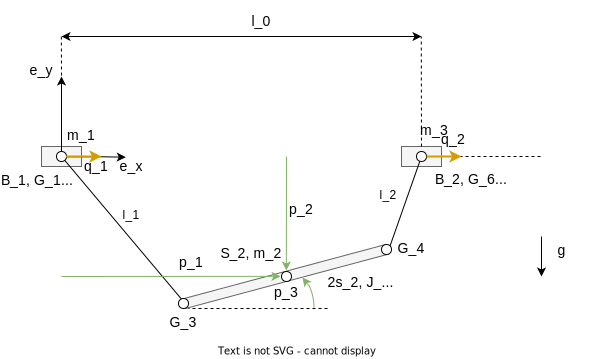

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

---

---

---

---

---

---

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")


Specify the geometry (joints G and centers of masses S)

#### Quasistatic state feedback control

In [5]:
# load model etc. from pickle of flatness analysis notebook
with open("flatness_analysis_control.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

Nonlinearities are chosen to be the new inputs of the system:
\begin{align}
    v_1 &:= \ddot{p}_1 = \ddot{y}_1 \\
    v_2 &:= \ddddot{p}_2 = \ddddot{y}_2 \\
    v_3 &:= \ddot{p}_3 = \ddot{y}_3 \\
    v_4 &:= \ddot{q}_1 = \ddot{y}_4 
\end{align}

In [6]:
vv = st.symb_vector("v1:{0}".format(4+1)) # vector of new inputs
vvd = st.time_deriv(vv, vv)
vvdd = st.time_deriv(vv, vv, order=2)

st.make_global(vv, vvd, vvdd)

In [7]:
ttaud = st.time_deriv(ttau, ttau)
ttaudd = st.time_deriv(ttau, ttau, order=2)

st.make_global(ttaud, ttaudd)

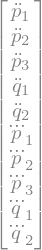

---

In [8]:
xxdot = st.time_deriv(mod.xx, mod.xx, order=1)
xxddot = st.time_deriv(mod.xx, mod.xx, order=2) ##:
xxdddot = st.time_deriv(mod.xx, mod.xx, order=3)

In [9]:
xx_ext = sp.Matrix(2*len(mod.xx) + 2*len(mod.tau) + 2*len(vv), 1, [*mod.xx, *xxddot, *ttau, *ttaud, *vv, *vvd])
fg_ext = sp.Matrix(2*len(mod.state_eq) + 2*len(mod.tau) + 2*len(vv), 1, [*mod.state_eq, *xxdddot, *ttaud, *ttaudd, *vvd, *vvdd])

In [10]:
y1_ext = xx_ext[0]
ydot1_ext = st.lie_deriv(y1_ext, fg_ext, xx_ext)
yddot1_ext = st.lie_deriv(ydot1_ext, fg_ext, xx_ext)
ydddot1_ext = st.lie_deriv(yddot1_ext, fg_ext, xx_ext)
yddddot1_ext = st.lie_deriv(ydddot1_ext, fg_ext, xx_ext)

ydot1_ext.s ##:
yddot1_ext.s ##:
ydddot1_ext.s ##:
yddddot1_ext.s ##:

---

---

---

---

In [11]:
y2_ext = xx_ext[1]
ydot2_ext = st.lie_deriv(y2_ext, fg_ext, xx_ext)
yddot2_ext = st.lie_deriv(ydot2_ext, fg_ext, xx_ext)
ydddot2_ext = st.lie_deriv(yddot2_ext, fg_ext, xx_ext)
yddddot2_ext = st.lie_deriv(ydddot2_ext, fg_ext, xx_ext)

ydot2_ext.s ##:
yddot2_ext.s ##:
ydddot2_ext.s ##:
yddddot2_ext.s ##:

---

---

---

---

In [12]:
y3_ext = xx_ext[2]
ydot3_ext = st.lie_deriv(y3_ext, fg_ext, xx_ext)
yddot3_ext = st.lie_deriv(ydot3_ext, fg_ext, xx_ext)
ydddot3_ext = st.lie_deriv(yddot3_ext, fg_ext, xx_ext)
yddddot3_ext = st.lie_deriv(ydddot3_ext, fg_ext, xx_ext)

ydot3_ext.s ##:
yddot3_ext.s ##:
ydddot3_ext.s ##:
yddddot3_ext.s ##:

---

---

---

---

In [13]:
y4_ext = xx_ext[3]
ydot4_ext = st.lie_deriv(y4_ext, fg_ext, xx_ext)
yddot4_ext = st.lie_deriv(ydot4_ext, fg_ext, xx_ext)
ydddot4_ext = st.lie_deriv(yddot4_ext, fg_ext, xx_ext)
yddddot4_ext = st.lie_deriv(ydddot4_ext, fg_ext, xx_ext)

ydot4_ext.s ##:
yddot4_ext.s ##:
ydddot4_ext.s ##:
yddddot4_ext.s ##:

---

---

---

---

In [14]:
# v_j = m_i * tau_i + n_i

In [15]:
m1 = yddot4_ext.diff(tau1)
n1 = yddot4_ext.subs(tau1, 0)
tau1_impl = (v4 - n1)/ m1
tau1_impl.s ##:
tau1_impl.co ##:

---

---

In [16]:
m2 = yddddot2_ext.diff(tau2)
n2 = yddddot2_ext.subs(tau2, 0)
tau2_impl = (v2 - n2)/ m2
tau2_impl.s ##:
tau2_impl.co ##:

---

---

In [17]:
m3 = yddot1_ext.diff(tau3)
n3 = yddot1_ext.subs(tau3, 0)
tau3_impl = (v1 - n3)/ m3
tau3_impl.s ##:
tau3_impl.co ##:

---

---

In [18]:
m4 = yddot3_ext.diff(tau4)
n4 = yddot3_ext.subs(tau4, 0)
tau4_impl = (v3 - n4)/ m4
tau4_impl.s ##:
tau4_impl.co ##:

---

---

In [19]:
sol_tau134 = sp.solve((tau1-tau1_impl, tau3-tau3_impl, tau4-tau4_impl), tau1, tau3, tau4)

In [20]:
tau1_expl = sol_tau134[tau1].smplf
tau3_expl = sol_tau134[tau3].smplf
tau4_expl = sol_tau134[tau4].smplf

In [21]:
tau1_expl.s ##:
tau1_expl.co ##:
tau3_expl.s ##:
tau3_expl.co ##:
tau4_expl.s ##:
tau4_expl.co ##:

---

---

---

---

---

---

In [22]:
tau3_expl_dot = st.lie_deriv(tau3_expl, fg_ext, xx_ext)
tau3_expl_dot.s ##:
tau3_expl_dot.co ##:
tau3_expl_ddot = st.lie_deriv(tau3_expl_dot, fg_ext, xx_ext)
tau3_expl_ddot.s ##:
tau3_expl_ddot.co ##:

tau4_expl_dot = st.lie_deriv(tau4_expl, fg_ext, xx_ext)
tau4_expl_dot.s ##:
tau4_expl_dot.co ##:
tau4_expl_ddot = st.lie_deriv(tau4_expl_dot, fg_ext, xx_ext)
tau4_expl_ddot.s ##:
tau4_expl_ddot.co ##:

---

---

---

---

---

---

---

---

In [23]:
tau2_expl = tau2_impl.subz([tauddot3, tauddot4, taudot3, taudot4, tau1, tau3, tau4], 
                             [tau3_expl_ddot, tau4_expl_ddot, tau3_expl_dot, tau4_expl_dot, tau1_expl, tau3_expl, tau4_expl])
tau2_expl.s ##:
tau2_expl.co ##:

mc2 = tau2_expl.diff(tau2)
nc2 = tau2_expl.subs(tau2, 0)

tau2_expl = 1/(1-mc2) * nc2
tau2_expl.s ##:
tau2_expl.co ##:

---

---

---

---

#### State feedback for control

In [24]:
# define symbols for measured states
p_meas = st.symb_vector("pm1:{0}".format(3+1)) # error vector of passive coordinates
q_meas = st.symb_vector("qm1:{0}".format(2+1)) # error vector of actuated coordinates

meas_states = st.row_stack(p_meas, q_meas)
meas_states_d = st.time_deriv(meas_states, meas_states)
meas_states_dd = st.time_deriv(meas_states, meas_states, order=2)
meas_states_ddd = st.time_deriv(meas_states, meas_states, order=3)
meas_states_dddd = st.time_deriv(meas_states, meas_states, order=4)

st.make_global(meas_states, meas_states_d, meas_states_dd, meas_states_ddd, meas_states_dddd)

# define symbols for reference trajectory states
p_ref = st.symb_vector("pr1:{0}".format(3+1)) # error vector of passive coordinates
q_ref = st.symb_vector("qr1:{0}".format(2+1)) # error vector of actuated coordinates

ref_states = st.row_stack(p_ref, q_ref)
ref_states_d = st.time_deriv(ref_states, ref_states)
ref_states_dd = st.time_deriv(ref_states, ref_states, order=2)
ref_states_ddd = st.time_deriv(ref_states, ref_states, order=3)
ref_states_dddd = st.time_deriv(ref_states, ref_states, order=4)

st.make_global(ref_states, ref_states_d, ref_states_dd, ref_states_ddd, ref_states_dddd)

#### Linear feedback error:
$$
e := y - y_{\text{ref}}
$$

#### Error dynamics:
$$
e^{(n)} + c_{n-1} e^{(n-1)} + ... + c_{1} \dot{e} + c_{0} e = 0 
\Leftrightarrow y^{(n)} = y_{\text{ref}}^{(n)} - c_{n-1} e^{(n-1)} - ... - c_{1} \dot{e} - c_{0} e
$$

In [132]:
v1_expr = prddot1 #+ 2*(prdot1 - pdot1) + (pr1 - p1) ##:
v3_expr = prddot3 #+ 2*(prdot3 - pdot3) + (pr3 - p3) ##:
v4_expr = qrddot1 #+ 2*(qrdot1 - qdot1) + (qr1 - q1) ##:

---

---

---

##### Quasi static state feedback for $\dot{v}_1$, $\ddot{v}_1$, $\dot{v}_3$, $\ddot{v}_3$:
\begin{align}
    \ddot{e} + c_1 \dot{e} + c_0 e &= 0 \\
    e^{(3)} + c_1 \ddot{e} + c_0 \dot{e} &= 0 \\
    e^{(3)} + c_1 (-c_1 \dot{e} - c_0 e) + c_0 \dot{e} &= 0 \\
    e^{(3)} - c_1^2 \dot{e} + c_0 \dot{e} - c_0 c_1 e &= 0 \\
    e^{(3)} + (c_0 - c_1^2) \dot{e} - c_0 c_1 e &= 0 \\
    e^{(4)} + (c_0 - c_1^2) \ddot{e} - c_0 c_1 \dot{e} &= 0 \\
    e^{(4)} + (c_0 - c_1^2) (-c_1 \dot{e} - c_0 e) - c_0 c_1 \dot{e} &= 0 \\
    e^{(4)} + (c_1^2 - 2 c_0 c_1) \dot{e} + (c_0 c_1^2 - c_0^2) e &= 0 \\
    \Rightarrow y^{(3)} &= y_{\text{ref}}^{(3)} - (c_0 - c_1^2) \dot{e} + c_0 c_1 e \\
    \Rightarrow y^{(4)} &= y_{\text{ref}}^{(4)} - (c_1^3 - 2 c_0 c_1) \dot{e} - (c_0 c_1^2 - c_0^2) e
\end{align}

In [134]:
# vdot1 = y1^(3)
vdot1_expr = prdddot1 #+ 3*(prdot1 - pdot1) + 2*(pr1 - p1)
# vddot1 = y1^(4)
vddot1_expr = prddddot1 #- 4*(prdot1 - pdot1) - 3*(pr1 - p1)

# vdot3 = y3^(3)
vdot3_expr = prdddot3 #+ 3*(prdot3 - pdot3) + 2*(pr3 - p3)
# vddot3 = y3^(4)
vddot3_expr = prddddot3 #- 4*(prdot3 - pdot3) - 3*(pr3 - p3)

In [135]:
pddot2_expr = mod.f[-4] + (mod.g[-4, :] * ttau)[0]
pddot2_expr.s ##:
pddot2_expr_traj = pddot2_expr.subz([tau3, tau4, v1, v3], [tau3_expl, tau4_expl, v1_expr, v3_expr])
pddot2_expr_traj.s ##:

---

---

In [136]:
pdddot2_expr = st.lie_deriv(pddot2_expr, fg_ext, xx_ext)
pdddot2_expr.s ##:
pdddot2_expr_traj = pdddot2_expr.subz([taudot3, taudot4, tau3, tau4, vdot1, vdot3, v1, v3], 
                                      [tau3_expl_dot, tau4_expl_dot, tau3_expl, tau4_expl, vdot1_expr, vdot3_expr,v1_expr, v3_expr])
pdddot2_expr_traj.s ##:
pdddot2_expr_traj.co ##:

---

---

---

In [139]:
v2_expr = prddddot2 #+ 4*(prdddot2 - pdddot2) + 6*(prddot2 - pddot2) + 4*(prdot2 - pdot2) + 1 ##:
v2_expr = v2_expr.subz([pddot2, pdddot2], [pddot2_expr_traj, pdddot2_expr_traj])
v2_expr.s ##:

---

---

In [140]:
### substitute new inputs into tau

In [141]:
tau1_expl.s ##:
qstat_tau1 = tau1_expl.subz([v1, v3, v4], [v1_expr, v3_expr, v4_expr])
qstat_tau1 = qstat_tau1.subz([*tthetad, *ttheta], [*meas_states_d, *meas_states])
qstat_tau1.s ##:
qstat_tau1.co ##:

---

---

---

In [142]:
tau3_expl.s ##:
qstat_tau3 = tau3_expl.subz([v1, v3], [v1_expr, v3_expr])
qstat_tau3 = qstat_tau3.subz([*tthetad, *ttheta], [*meas_states_d, *meas_states])
qstat_tau3.s ##:
qstat_tau3.co ##:

---

---

---

In [143]:
tau4_expl.s ##:
qstat_tau4 = tau4_expl.subz([v1, v3], [v1_expr, v3_expr])
qstat_tau4 = qstat_tau4.subz([*tthetad, *ttheta], [*meas_states_d, *meas_states])
qstat_tau4.s ##:
qstat_tau4.co ##:

---

---

---

In [144]:
tau2_expl.s ##:
qstat_tau2 = tau2_expl.subz([v1, v2, v3, v4, vdot1, vdot3, vddot1, vddot3], 
                             [v1_expr, v2_expr, v3_expr, v4_expr, vdot1_expr, vdot3_expr, vddot1_expr, vddot3_expr])
qstat_tau2 = qstat_tau2.subz([*tthetad, *ttheta], [*meas_states_d, *meas_states])
qstat_tau2.s ##:
qstat_tau2.co ##:

---

---

---

In [145]:
num1, den1 = sp.fraction(qstat_tau1)
num2, den2 = sp.fraction(qstat_tau2)
num3, den3 = sp.fraction(qstat_tau3)
num4, den4 = sp.fraction(qstat_tau4)

In [52]:
num2a, den2a = qstat_tau2.as_numer_denom()
diff_n = num2 - num2a
diff_d = den2 -den2a

In [60]:
den2.co ##:
den2a.co ##:

---

---

In [64]:
sp.cse?

In [58]:
num2.srn ##:
num2a.co ##:


KeyboardInterrupt



In [53]:
diff_n.srn


KeyboardInterrupt



In [81]:
den2_cse_rp, (den2_cse_exprs,) = sp.cse(den2)

In [82]:
den2_cse_rp[:3]

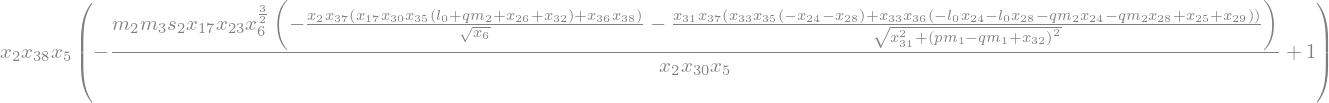

In [83]:
den2_cse_exprs

In [84]:
den2_cse_exprs_num, den2_cse_exprs_den = den2_cse_exprs.as_numer_denom()

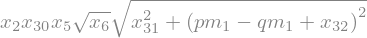

In [85]:
den2_cse_exprs_den

In [117]:
qstat_tau2_cse_rp, (qstat_tau2_cse_exprs,) = sp.cse(qstat_tau2)
qstat_tau2_cse_rp_reversed = qstat_tau2_cse_rp[::-1]

In [119]:
qstat_tau2_cse_rp[:4]

In [120]:
qstat_tau2_cse_rp_reversed[:4]

In [87]:
qstat_tau2_cse_exprs_num, qstat_tau2_cse_exprs_den = qstat_tau2_cse_exprs.as_numer_denom()

In [88]:
qstat_tau2_cse_exprs_den

In [116]:
qstat_tau2_cse_rp_reversed[:4]

In [121]:
qstat_tau2_den = qstat_tau2_cse_exprs_den.subs(qstat_tau2_cse_rp_reversed)

In [122]:
den2.co

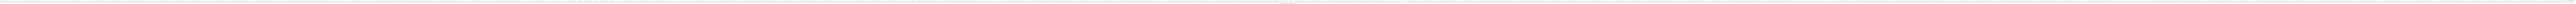

In [123]:
qstat_tau2_cse_exprs

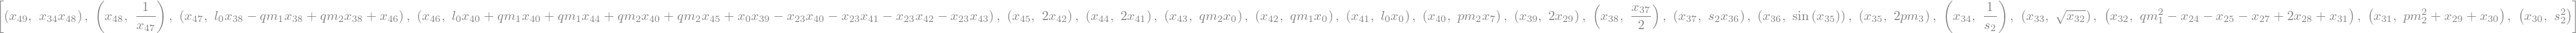

In [111]:
qstat_tau2_cse_rp.reverse()
qstat_tau2_cse_rp[:4]

In [126]:
sys_params = list(dict(J2=0.004553475, g=9.81, l0=0.3, m1=0.45, m2=0.557, m3=0.45, s2=0.15).items()) ##:

sys_params := [('J2', 0.004553475),
 ('g', 9.81),
 ('l0', 0.3),
 ('m1', 0.45),
 ('m2', 0.557),
 ('m3', 0.45),
 ('s2', 0.15)]

---

In [125]:
xx5 = npy.array([0, -5.5000000000e-01, -1.5000000000e-01, -1.5000000000e-01, -1.4985510823e-01, -7.3828125000e-02, -7.3828125000e-02, -7.3828125000e-02, -5.6250000000e-02, -8.9979908736e-02])

In [ ]:
for rp in qstat_tau2_cse_rp:
    rp

In [130]:
den2.s

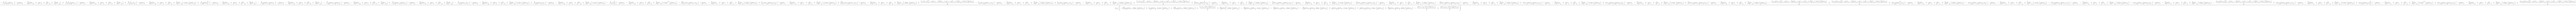

In [131]:
qstat_tau1

In [ ]:
################################

In [146]:
numerators = [num1, num2, num3, num4]
denominators = [den1, den2, den3, den4]

In [147]:
# store with pickle
pickle_data = {"qstat_tau1":qstat_tau1, "qstat_tau2":qstat_tau2, "qstat_tau3":qstat_tau3, "qstat_tau4":qstat_tau4, "numerators":numerators, "denominators":denominators}

with open("qstat_expr.pcl", "wb") as pfile:
    pickle.dump(pickle_data, pfile)

In [39]:
# coefficients for error dynamics
# Polynome: s^2 + c_i[1] s + c_i[0] s
cp1 = [1, 2]
cp2 = [1, 2]
cp3 = [1, 2]
cq1 = [1, 2]
c2 = sp.Matrix([cp1, cp2, cp3, cq1, [0, 0]])

Every component of the flat output $\mathbf{y}$ appearing in $\mathbf{\tau}$ with a higher order derivative than 1 has to be substituted, becaus it is assumed that only positions and speeds of $\mathbf{y}$ can be measured directly.

##### State feedback error dynamics:
\begin{align}
    \ddot{e} + c_1 \dot{e} + c_0 e &= 0 \\
\end{align}

In [62]:
from sympy.matrices.dense import matrix_multiply_elementwise as elmul

In [63]:
c2_00 = elmul(c2[:, 0], c2[:, 0])
c2_01 = elmul(c2[:, 0], c2[:, 1])
c2_11 = elmul(c2[:, 1], c2[:, 1])
c2_111 = elmul(elmul(c2[:, 1], c2[:, 1]), c2[:, 1])
c2_011 = elmul(elmul(c2[:, 0], c2[:, 1]), c2[:, 1])

In [64]:
meas_subs_dd = ref_states_dd - elmul(c2[:, 1], (meas_states_d - ref_states_d)) - elmul(c2[:, 0], (meas_states - ref_states)) ##:

meas_subs_dd := ⎡-pm₁ - 2⋅pṁ₁ + pr₁ + pr̈₁ + 2⋅pṙ₁⎤
⎢                                ⎥
⎢-pm₂ - 2⋅pṁ₂ + pr₂ + pr̈₂ + 2⋅pṙ₂⎥
⎢                                ⎥
⎢-pm₃ - 2⋅pṁ₃ + pr₃ + pr̈₃ + 2⋅pṙ₃⎥
⎢                                ⎥
⎢-qm₁ - 2⋅qṁ₁ + qr₁ + qr̈₁ + 2⋅qṙ₁⎥
⎢                                ⎥
⎣              qr̈₂               ⎦

---

In [65]:
# for quasi static state feedback approach
meas_subs_ddd = ref_states_ddd - elmul((c2[:, 0] - c2_11), (meas_states_d - ref_states_d)) + elmul(c2_01, (meas_states - ref_states)) ##:
meas_subs_dddd = ref_states_dddd - elmul((c2_111 - 2*c2_01), (meas_states_d - ref_states_d)) - elmul((c2_011 - c2_00), (meas_states - ref_states)) ##:

meas_subs_ddd := ⎡2⋅pm₁ + 3⋅pṁ₁ - 2⋅pr₁ + pr⃛₁ - 3⋅pṙ₁⎤
⎢                                   ⎥
⎢2⋅pm₂ + 3⋅pṁ₂ - 2⋅pr₂ + pr⃛₂ - 3⋅pṙ₂⎥
⎢                                   ⎥
⎢2⋅pm₃ + 3⋅pṁ₃ - 2⋅pr₃ + pr⃛₃ - 3⋅pṙ₃⎥
⎢                                   ⎥
⎢2⋅qm₁ + 3⋅qṁ₁ - 2⋅qr₁ + qr⃛₁ - 3⋅qṙ₁⎥
⎢                                   ⎥
⎣                qr⃛₂                ⎦

---

meas_subs_dddd := ⎡-3⋅pm₁ - 4⋅pṁ₁ + 3⋅pr₁ + pr⃜₁ + 4⋅pṙ₁⎤
⎢                                    ⎥
⎢-3⋅pm₂ - 4⋅pṁ₂ + 3⋅pr₂ + pr⃜₂ + 4⋅pṙ₂⎥
⎢                                    ⎥
⎢-3⋅pm₃ - 4⋅pṁ₃ + 3⋅pr₃ + pr⃜₃ + 4⋅pṙ₃⎥
⎢                                    ⎥
⎢-3⋅qm₁ - 4⋅qṁ₁ + 3⋅qr₁ + qr⃜₁ + 4⋅qṙ₁⎥
⎢                                    ⎥
⎣                qr⃜₂                 ⎦

---

#### Inputs from flat output

In [66]:
yddddot2_ext.s

In [67]:
sol_tau134 = sp.solve((pddot1-yddot1_ext, pddot3-yddot3_ext, qddot1-yddot4_ext), tau1, tau3, tau4)

In [68]:
tau1_alg = sol_tau134[tau1].smplf
tau3_alg = sol_tau134[tau3].smplf
tau4_alg = sol_tau134[tau4].smplf

In [70]:
tau1_alg.s ##:
tau1_alg.co ##:
tau3_alg.s ##:
tau3_alg.co ##:
tau4_alg.s ##:
tau4_alg.co ##:

---

---

---

---

---

---

In [74]:
tau1_alg_flat = tau1_alg.subs(q2, flat_q2)
tau3_alg_flat = tau3_alg.subs(q2, flat_q2)
tau4_alg_flat = tau4_alg.subs(q2, flat_q2)

In [75]:
tau1_alg_flat = tau1_alg_flat.subz([*tthetadd, *tthetad, *ttheta], [*meas_subs_dd, *meas_states_d, *meas_states])
tau3_alg_flat = tau3_alg_flat.subz([*tthetadd, *tthetad, *ttheta], [*meas_subs_dd, *meas_states_d, *meas_states])
tau4_alg_flat = tau4_alg_flat.subz([*tthetadd, *tthetad, *ttheta], [*meas_subs_dd, *meas_states_d, *meas_states])

In [76]:
tau1_alg_flat.s ##:
tau1_alg_flat.co ##:
tau3_alg_flat.s ##:
tau3_alg_flat.co ##:
tau4_alg_flat.s ##:
tau4_alg_flat.co ##:

---

---

---

---

---

---

In [77]:
taudot3_alg = st.lie_deriv(tau3_alg, fg_ext, xx_ext, order=1)
tauddot3_alg = st.lie_deriv(taudot3_alg, fg_ext, xx_ext, order=1)
taudot4_alg = st.lie_deriv(tau4_alg, fg_ext, xx_ext, order=1)
tauddot4_alg = st.lie_deriv(taudot4_alg, fg_ext, xx_ext, order=1)

In [79]:
flat_q2.s

In [80]:
flat_qddot2 = st.lie_deriv(flat_q2, fg_ext, xx_ext, order=2)
flat_qddot2.s

In [81]:
flat_qddot2.co

flat_qddot2 is already to large and would also need a substitution of the control forces $\tau_1, \tau_3, \tau_4$ to then be used in a representation of $\tau_2$

In [82]:
# store with pickle
pickle_data = {"qstat_tau1":tau1_alg_flat, "qstat_tau2":qstat_tau2, "qstat_tau3":tau3_alg_flat, "qstat_tau4":tau4_alg_flat}

with open("qstat_expr.pcl", "wb") as pfile:
    pickle.dump(pickle_data, pfile)